Полезные ссылки:  
ДЗ: https://docs.google.com/document/d/1DneunZ0i5-3jERFVu0-1Q_x0fhsa7TAbukb8sPTsNg4/  
Окружение из gym: https://github.com/openai/gym/blob/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/toy_text/blackjack.py  
Дополнительная информация:  
Шпаргалка: https://github.com/udacity/deep-reinforcement-learning/blob/master/cheatsheet/cheatsheet.pdf  
https://habr.com/ru/company/otus/blog/477042/  
https://www.cs.ubc.ca/labs/lci/mlrg/slides/mlrg_MonteCarlo.pdf  


# Advanced DL and RL: Домашнее задание 1
Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том числе и достаточно техническое, так что для решения придётся немножко попрограммировать. Поэтому в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

## Часть первая, с блекджеком и стратегиями
Мы будем обучаться играть в очень простую, но всё-таки знаменитую и популярную игру: блекджек. Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:  
* численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;  
* игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;  
* игрок может совершать одно из двух действий:  
    * hit  — взять ещё одну карту;  
    * stand — не брать больше карт;  
* если сумма очков у игрока на руках больше 21, он проигрывает (bust);  
* если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;  
* после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);  
* в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).  
Именно этот простейший вариант блекджека реализован в OpenAI Gym:  
https://github.com/openai/gym/blob/38a1f630dc9815a567aaf299ae5844c8f8b9a6fa/gym/envs/toy_text/blackjack.py

In [1]:
import sys
import random
from collections import defaultdict
import statistics
import copy

import threading
import multiprocessing

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})
%matplotlib inline

import gym
from gym import error, spaces, utils
from gym.utils import seeding
from gym.envs.registration import register, registry
from gym.envs.toy_text.blackjack import *

Реализуем функцию, производящую игру и запоминающую историю состояний, действий, вознаграждений за игру. Реализация универсальная (для разных стратегий, окружений, можно задать seed и напечать ход игры).

In [56]:
def play_blackjack(strategy, env=gym.make('Blackjack-v0', natural=True), verbose=False, seed=None, action_names=["Больше не берём.", "Берём карту."], *args, **kwargs): 
    """Запускает игру для указанного окружения по выбранной стратегии. 
    Записывает и возвращает историю игры: состояния, действия, вознаграждения.
    Можно напечать на экран ход игры.
    
    Аргументы:
    strategy -- Стратегия игры.
    env -- окружение для игры.
    verbose -- Нужно ли печатать ход игры?
    seed -- Начальное состояние генераторов случайных чисел для окружения.
    action_names -- Названия действий для печати хода игры.
    Остальные аргументы будут переданы в стратегию.
    """
    states, actions, rewards = [], [], []  # В эти списки запишем историю игры.
    if seed is not None:  # Инициализируем генератор случайных чисел в окружении.
        env.seed(seed)
        env.action_space.seed(seed)
    initial = env.reset()  # Начинаем новую игру
    if verbose: print("Начальная раздача: ", initial)
    while True:
        states.append(env._get_obs())
        
        action = strategy(env, *args, **kwargs)  # Выбираем действие в соответствии со стратегией.
        actions.append(action)
        if verbose:
            print(action_names[action])
        
        new_state, reward, done, info = env.step(action)  # Делаем ход.
        rewards.append(reward)
        
        if verbose: print(new_state, reward, done, info)
        if done:  # Игра окончена
            if verbose:
                if reward > 0:
                    print("Победа.")
                elif reward < 0:
                    print("Поражение.")
                else:
                    print("Ничья.")
            break
    env.close()
    return (states, actions, rewards)

Реализуем стратегию случайной игры (равновероятно выбираем действие на каждом шаге).

In [3]:
def random_strategy(env):
    return env.action_space.sample()

Проверим, как это работает:

In [4]:
play_blackjack(random_strategy, verbose=True)

Начальная раздача:  (14, 4, False)
Берём карту.
(24, 4, False) -1.0 True {}
Поражение.


([(14, 4, False)], [1], [-1.0])

Проверим, как seed устанавливается, хотя нам это может не пригодиться далее:

In [5]:
last = play_blackjack(random_strategy, verbose=False, seed=1)
for i in range(10):
    new = play_blackjack(random_strategy, verbose=False, seed=1)
    if last != new:
        print("Seed не работает.")
    last = new
print("Seed работает.")

Seed работает.


Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [6]:
def simple_strategy(env):
    if env._get_obs()[0] >= 19:
        return 0
    else:
        return 1

In [7]:
play_blackjack(simple_strategy, verbose=True)

Начальная раздача:  (20, 3, False)
Больше не берём.
(20, 3, False) 0.0 True {}
Ничья.


([(20, 3, False)], [0], [0.0])

Оценим состояния игры с помощью First-visit MC prediction для данной стратегии.  
По определению:  
![MC](https://habrastorage.org/webt/u4/kd/o_/u4kdo_uc3dj64rihmdjhnyj1r7y.png)  
Побыстрее:  
![MC](https://miro.medium.com/max/337/1*-gWLzZ9hduVq-dfS9NsDLQ.png)  

In [8]:
def first_visit_mc_prediction(strategy, env=gym.make('Blackjack-v0', natural=True), n_episodes=10000, gamma=0.8, seed=None):
    """Оценка состояний игры методом Монте Карло. Учитывается только первое посещение состояния.
    Медленный вариант алгоритма по определению метода.
    
    Аргументы:
    strategy -- Стратегия игры.
    env -- окружение для игры.
    n_episodes -- Количество игр.
    gamma -- Коэффициент, с которым затухают вознаграждения при распространении в прошлое.
    seed -- Начальное состояние генераторов случайных чисел для окружения.
    """
    values = defaultdict(float)
    returns = defaultdict(list)
    
    env.seed(seed)
    env.action_space.seed(seed)
    
    for episode_no in range(n_episodes):
        if (episode_no + 1) % 10000 == 0:
            print("Episode {}/{}.".format(episode_no + 1, n_episodes))
            sys.stdout.flush()
        states, _, rewards = play_blackjack(strategy, env)
        G = 0.0
        for t in range(len(states) - 1, -1, -1):
            R = rewards[t]
            G = gamma * G + R
            S = states[t]
            if S not in states[:t]:
                returns[S].append(G)
                values[S] = statistics.mean(returns[S])
    return values

In [9]:
%%time
values = first_visit_mc_prediction(simple_strategy, gym.make('Blackjack-v0', natural=True), n_episodes=100000)
print(list(values.items())[0:10])
print(statistics.mean(values.values()))

Episode 10000/100000.
Episode 20000/100000.
Episode 30000/100000.
Episode 40000/100000.
Episode 50000/100000.
Episode 60000/100000.
Episode 70000/100000.
Episode 80000/100000.
Episode 90000/100000.
Episode 100000/100000.
[((20, 8, False), 0.8060941828254847), ((10, 8, False), 0.007525628140703517), ((8, 8, False), -0.3083034482758621), ((20, 10, False), 0.4219187675070028), ((21, 10, True), 1.2634947134112409), ((21, 8, False), 0.9206842923794712), ((13, 8, False), -0.4026965675057208), ((18, 10, False), -0.683950035352345), ((14, 10, False), -0.5315094105480869), ((15, 10, False), -0.5625662620757989)]
-0.07484746166320207
CPU times: user 1min 28s, sys: 79 ms, total: 1min 28s
Wall time: 1min 28s


Чтобы избежать хранения всех результатов в списке, мы можем выполнить процедуру обновления значения состояния в методе Монте-Карло постепенно, с помощью уравнения, которое имеет некоторое сходство с традиционным градиентным спуском:
![opt](https://habrastorage.org/webt/lv/tm/nk/lvtmnki_ff4csblmytygnnxjn6u.png)

Инкрементная процедура обновления Монте-Карло. S – это состояние, V – его значение, G – его результат, а alpha – параметр значения шага.

In [10]:
def first_visit_mc_prediction_fast(strategy, env=gym.make('Blackjack-v0', natural=True), n_episodes=10000, gamma=0.8, alpha=None, seed=None):
    """Оценка состояний игры методом Монте Карло. Учитывается только первое посещение состояния.
    Быстрый вариант алгоритма с обновлением значения состояний по уравнению выше.
    
    Аргументы:
    strategy -- Стратегия игры.
    env -- окружение для игры.
    n_episodes -- Количество игр.
    gamma -- Коэффициент, с которым затухают вознаграждения при распространении в прошлое.
    alpha -- Коэффициент, задающий скорость обновления значений состояний, но обычно он не задаётся и равен 1/количество_посещений_состояния.
    seed -- Начальное состояние генераторов случайных чисел для окружения.
    """
    values = defaultdict(float)
    N = defaultdict(int)
    
    env.seed(seed)
    env.action_space.seed(seed)
    
    for episode_no in range(n_episodes):
        if (episode_no + 1) % 10000 == 0:
            print("Episode {}/{}.".format(episode_no + 1, n_episodes))
            sys.stdout.flush()
        states, _, rewards = play_blackjack(strategy, env)
        G = 0.0
        for t in range(len(states) - 1, -1, -1):
            R = rewards[t]
            G = gamma * G + R
            S = states[t]
            if S not in states[:t]:
                N[S] += 1
                if alpha is None:
                    values[S] += (G - values[S]) / N[S]
                else:
                    values[S] += (G - values[S]) * alpha
    return values

In [11]:
%%time
values = first_visit_mc_prediction_fast(simple_strategy, gym.make('Blackjack-v0', natural=True), n_episodes=100000)
print(list(values.items())[0:10])
print(statistics.mean(values.values()))

Episode 10000/100000.
Episode 20000/100000.
Episode 30000/100000.
Episode 40000/100000.
Episode 50000/100000.
Episode 60000/100000.
Episode 70000/100000.
Episode 80000/100000.
Episode 90000/100000.
Episode 100000/100000.
[((21, 10, False), 0.8882331243083718), ((15, 10, False), -0.5724229119354042), ((12, 3, False), -0.34093317702227444), ((18, 9, False), -0.649724770642203), ((14, 9, False), -0.4374444889779561), ((14, 2, False), -0.48228810020876794), ((18, 10, False), -0.6768585411326016), ((21, 6, True), 1.2499999999999987), ((21, 7, True), 1.3159448818897634), ((19, 10, False), -0.013304822998336954)]
-0.07733248912464968
CPU times: user 6.63 s, sys: 4.01 ms, total: 6.64 s
Wall time: 6.63 s


Попробуем распараллелить код на CPU.

In [12]:
def first_visit_mc_prediction_block(strategy, env, n_episodes, gamma, alpha, mutex, values, N): 
    for episode_no in range(n_episodes):
        states, _, rewards = play_blackjack(strategy, env)
        G = 0.0
        for t in range(len(states) - 1, -1, -1):
            R = rewards[t]
            G = gamma * G + R
            S = states[t]
            if S not in states[:t]:
                mutex.acquire()
                N[S] += 1
                if alpha is None:
                    values[S] += (G - values[S]) / N[S]
                else:
                    values[S] += (G - values[S]) * alpha
                mutex.release()

def first_visit_mc_prediction_fast_threading(strategy, env=gym.make('Blackjack-v0', natural=True), n_episodes=10000, gamma=0.8, alpha=None):
    """Оценка состояний игры методом Монте Карло. Учитывается только первое посещение состояния.
    Быстрый вариант алгоритма с обновлением значения состояний по уравнению выше. 
    Многопоточная реализация.
    
    Аргументы:
    strategy -- Стратегия игры.
    env -- окружение для игры.
    n_episodes -- Количество игр.
    gamma -- Коэффициент, с которым затухают вознаграждения при распространении в прошлое.
    alpha -- Коэффициент, задающий скорость обновления значений состояний, но обычно он не задаётся и равен 1/количество_посещений_состояния.
    """
    values = defaultdict(float)
    N = defaultdict(int)
    
    nthreads = multiprocessing.cpu_count()
    block_size = n_episodes // nthreads
    threads = []
    mutex = threading.Lock()
    for i in range(nthreads):
        thread = threading.Thread(target=first_visit_mc_prediction_block,
            args=(strategy, copy.copy(env), block_size, gamma, alpha, mutex, values, N),
            kwargs=None,
        )
        thread.start()
        threads.append(thread)
    for i in range(nthreads):
        threads[i].join()
    return values

In [13]:
%%time
values = first_visit_mc_prediction_fast_threading(simple_strategy, gym.make('Blackjack-v0', natural=True), n_episodes=100000)
print(list(values.items())[0:10])
print(statistics.mean(values.values()))

[((18, 10, False), -0.6999281781182646), ((12, 10, False), -0.4420556086461887), ((20, 7, False), 0.7745302713987477), ((15, 7, False), -0.5123640124095139), ((13, 7, False), -0.3940603448275864), ((15, 3, False), -0.5213077699293647), ((10, 3, False), 0.04135120643431642), ((21, 8, True), 1.3306636155606413), ((21, 7, True), 1.2957446808510642), ((21, 2, False), 0.8816568047337281)]
-0.0723772891567118
CPU times: user 36.9 s, sys: 4.07 s, total: 41 s
Wall time: 34 s


Видим, что в данной задаче затраты на управление потоками не окупают себя, будем пользоваться однопоточной реализацией.

Оценим средний выигрыш при данной стратегии:

In [14]:
def average_reward(strategy, env=gym.make('Blackjack-v0', natural=True), n_episodes=10000, verbose=True, play_function=play_blackjack, *args, **kwargs):
    """Оценка среднего выигрыша при заданной стратегии по большому количеству партий.
    
    Аргументы:
    strategy -- Стратегия игры.
    env -- окружение для игры.
    n_episodes -- Количество игр.
    verbose -- Нужно ли печатать прогресс вычисления на экран?
    play_function -- Функция, которая запускает игру и возвращает массивы состояний, действий, вознаграждений.
    Остальные аргументы будут переданы в play_function без изменений.
    """
    rewards = 0
    for episode_no in range(n_episodes):
        if verbose and (episode_no + 1) % (n_episodes // 10) == 0:
            print("Episode {}/{}.".format(episode_no + 1, n_episodes))
            sys.stdout.flush()
        rewards += play_function(strategy=strategy, env=env, verbose=False, *args, **kwargs)[-1][-1]
    return rewards / n_episodes

Проверим, как работает подсчёт среднего выигрыша на разных стратегиях. Стратегия выбора случайного действия:

In [15]:
%%time
print(average_reward(random_strategy, n_episodes=100000))

Episode 10000/100000.
Episode 20000/100000.
Episode 30000/100000.
Episode 40000/100000.
Episode 50000/100000.
Episode 60000/100000.
Episode 70000/100000.
Episode 80000/100000.
Episode 90000/100000.
Episode 100000/100000.
-0.386235
CPU times: user 6.7 s, sys: 0 ns, total: 6.7 s
Wall time: 6.7 s


Простая стратегия, описанная выше:

In [16]:
%%time
print(average_reward(simple_strategy, n_episodes=100000))

Episode 10000/100000.
Episode 20000/100000.
Episode 30000/100000.
Episode 40000/100000.
Episode 50000/100000.
Episode 60000/100000.
Episode 70000/100000.
Episode 80000/100000.
Episode 90000/100000.
Episode 100000/100000.
-0.18564
CPU times: user 6.16 s, sys: 239 ms, total: 6.4 s
Wall time: 6.42 s


Так же в интернете я нашёл такую стратегию игры:

In [17]:
def normal_strategy(env):
    """
    Returns appropriate action from a 2D array storing actions
    Each row corresponds to player sum- from 2 to 21
    Each column corresponds to dealer_up_card- from 1 to 10
    """
    actions = [[1]*10]*10 # 2 to 11
    actions.append([1]*2 + [0]*3 + [1]*5) #12
    actions.extend([[0]*6 + [1]*4]*4) #13-16
    actions.extend([[0]*10]*5) #17-21

    state = env._get_obs()
    return actions[state[0] - 2][state[1] - 2]

In [18]:
%%time
print(average_reward(normal_strategy, n_episodes=100000))

Episode 10000/100000.
Episode 20000/100000.
Episode 30000/100000.
Episode 40000/100000.
Episode 50000/100000.
Episode 60000/100000.
Episode 70000/100000.
Episode 80000/100000.
Episode 90000/100000.
Episode 100000/100000.
-0.04847
CPU times: user 6.36 s, sys: 24.9 ms, total: 6.39 s
Wall time: 6.4 s


Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

По определению:  
![](https://habrastorage.org/webt/nf/b4/nw/nfb4nwijndtfex4ytwhdn2ujcyw.png)  
Но так быстрее:  
![](https://www.machinelearningmastery.ru/img/0-230134-328120.png)

In [121]:
def eps_generator(eps_start=1.0, eps_min=0.01, decay=0.99999):
    """Генератор элементов убывающей геометрической прогрессии с ограничением значения минимального элемента.
    
    Аргументы:
    eps_start -- Первый элемент последовательности.
    eps_min -- Минимальное значение элементов.
    decay -- Знаменатель прогрессии.
    """
    epsilon = eps_start
    yield epsilon
    command = None
    while True:
        if command == "restart":  # Начать сначала
            epsilon = eps_start
            yield epsilon
        else:
            epsilon = max(epsilon*decay, eps_min)  # Новый член последовательности
        command = (yield epsilon)
        
def eps_greedy_strategy(env, epsilon, Q):
    """Эпсилон-жадная стратегия.
    С вероятностью эпсилон выбирает случайное действие, иначе - наиболее выгодное действие.
    
    Аргументы:
    env -- Окружение.
    epsilon -- Вероятность случайного действия.
    Q -- Выгода от действий в каждом состоянии dict: key - state, value - list values of actions.
    """
    state = env._get_obs()
    if random.random() > epsilon:
        return Q[state].argmax()
    else:
        return random.randint(0, env.action_space.n - 1)

def mc_control(env=gym.make('Blackjack-v0', natural=True), n_episodes=10000, gamma=0.2, eps_gen=eps_generator(), verbose=True, play_function=play_blackjack):
    """First-visit MC Control.
    Строит наиболее выгодную стратегию.
    Медленная реализация.
    
    Аргументы:
    env -- Окружение.
    n_episodes -- Количество игр.
    gamma -- Коэффициент, с которым затухают вознаграждения при распространении в прошлое.
    eps_gen -- Генератор, изменяющий эпсилон для эпсилон-жадной стратегии в процессе обучения.
    verbose -- Печатать ли на экран прогресс обучения?
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns = defaultdict(list)
    
    for episode_no in range(n_episodes):
        epsilon = next(eps_gen)
        if verbose and (episode_no + 1) % (n_episodes // 10) == 0:
            print("Episode {}/{}. Epsilon: {}.".format(episode_no + 1, n_episodes, epsilon))
            sys.stdout.flush()
        states, actions, rewards = play_function(eps_greedy_strategy, env, Q=Q, epsilon=epsilon)
        sa = list(zip(states, actions))
        G = 0
        for t in range(len(states) - 1, -1, -1):
            state = states[t]
            action = actions[t]
            reward = rewards[t]
            G = gamma * G + reward
            if (state, action) not in sa[:t]:
                returns[(state, action)].append(G)
                Q[state][action] = statistics.mean(returns[(state, action)])
    
    best_policy = lambda env, Q: eps_greedy_strategy(env, 0, Q)
    return best_policy, Q

def mc_control_fast(env=gym.make('Blackjack-v0'), n_episodes=10000, gamma=0.2, eps_gen=eps_generator(), verbose=True, play_function=play_blackjack):
    """First-visit MC Control.
    Строит наиболее выгодную стратегию.
    Быстрая реализация.
    
    Аргументы:
    env -- Окружение.
    n_episodes -- Количество игр.
    gamma -- Коэффициент, с которым затухают вознаграждения при распространении в прошлое.
    eps_gen -- Генератор, изменяющий эпсилон для эпсилон-жадной стратегии в процессе обучения.
    verbose -- Печатать ли на экран прогресс обучения?
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(int)
    
    for episode_no in range(n_episodes):
        epsilon = next(eps_gen)
        if verbose and (episode_no + 1) % (n_episodes // 10) == 0:
            print("Episode {}/{}. Epsilon: {}.".format(episode_no + 1, n_episodes, epsilon))
            sys.stdout.flush()
        # try:
        states, actions, rewards = play_function(strategy=eps_greedy_strategy, env=env, Q=Q, epsilon=epsilon)
        # except Exception as e:
        #     print(env._get_obs())
        #     print(env.deck)
        sa = list(zip(states, actions))
        G = 0
        for t in range(len(states) - 1, -1, -1):
            state = states[t]
            action = actions[t]
            reward = rewards[t]
            G = gamma * G + reward
            if (state, action) not in sa[:t]:
                N[(state, action)] += 1
                Q[state][action] += (G - Q[state][action]) / N[(state, action)]
    
    best_policy = lambda env, Q: eps_greedy_strategy(env, 0, Q)
    return best_policy, Q

In [22]:
# Можем проверить работу медленного алгоритма, но в этом нет необходимости:
# %%time
# best_policy, Q_for_best_policy = mc_control(n_episodes=1000000, verbose=False)
# print(average_reward(best_policy, n_episodes=1000000, Q=Q_for_best_policy, verbose=False))

In [23]:
%%time
n_episodes = 1000000
best_policy, Q_for_best_policy = mc_control_fast(n_episodes=n_episodes, eps_gen=eps_generator(eps_start=1.0, eps_min=0.01, decay=0.01**(1/n_episodes)))
print(average_reward(best_policy, n_episodes=n_episodes, Q=Q_for_best_policy, verbose=False))

Episode 100000/1000000. Epsilon: 0.6309602501516386.
Episode 200000/1000000. Epsilon: 0.3981090039074759.
Episode 300000/1000000. Epsilon: 0.25118979991863927.
Episode 400000/1000000. Epsilon: 0.15849004911687575.
Episode 500000/1000000. Epsilon: 0.10000046051712816.
Episode 600000/1000000. Epsilon: 0.0630960250145623.
Episode 700000/1000000. Epsilon: 0.039810900390368394.
Episode 800000/1000000. Epsilon: 0.025118979991624307.
Episode 900000/1000000. Epsilon: 0.01584900491153603.
Episode 1000000/1000000. Epsilon: 0.01000004605161713.
-0.031751
CPU times: user 2min 28s, sys: 1.09 s, total: 2min 29s
Wall time: 2min 26s


Посмотрим глазами на результат:

In [24]:
Q_for_best_policy

defaultdict(<function __main__.mc_control_fast.<locals>.<lambda>()>,
            {(10, 6, False): array([-0.13151365,  0.04019116]),
             (13, 10, False): array([-0.57734205, -0.40930099]),
             (20, 7, False): array([ 0.76090842, -0.92820069]),
             (15, 2, False): array([-0.2987823 , -0.53683666]),
             (9, 4, False): array([-0.24610592,  0.0106543 ]),
             (10, 9, False): array([-0.49019608,  0.00547975]),
             (12, 1, False): array([-0.83461963, -0.34833578]),
             (20, 2, False): array([ 0.63918287, -0.91926978]),
             (21, 2, False): array([ 0.88242574, -1.        ]),
             (21, 2, True): array([ 0.8847903 , -0.00890869]),
             (14, 10, True): array([-0.59381898, -0.02746461]),
             (15, 2, True): array([-0.04093567, -0.00288203]),
             (14, 10, False): array([-0.56498532, -0.4759035 ]),
             (15, 4, True): array([-0.24528302, -0.00078463]),
             (19, 10, False): array([

Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [33]:
def mc_control_plot(env=gym.make('Blackjack-v0', natural=True), n_episodes=10000, n_episodes_test=100000, gamma_begin=0.0, gamma_end=1.0, eps_gen=eps_generator(), verbose=True):
    """First-visit MC Control.
    Строит наиболее выгодную стратегию и записывает изменение среднего выигрыша в процессе обучения.
    Перебирает гамму (коэффициент, с которым затухают вознаграждения при распространении в прошлое).
    
    Аргументы:
    env -- Окружение.
    n_episodes -- Количество игр для обучения.
    n_episodes_test -- Количество игр для подсчёта среднего выигрыша.
    gamma_begin -- Левая граница диапазона для перебора коэффициента.
    gamma_end -- Правая граница диапазона для перебора коэффициента.
    eps_gen -- Генератор, изменяющий эпсилон для эпсилон-жадной стратегии в процессе обучения.
    verbose -- Печатать ли на экран прогресс обучения?
    """
    
    all_rewards = []
    gammas = np.linspace(gamma_begin, gamma_end, num=5)
    for gamma in gammas:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
        N = defaultdict(int)
        try:
            eps_gen.send("restart")
        except Exception as e:
            pass
        rewards_gamma = []
        for episode_no in range(n_episodes):
            epsilon = next(eps_gen)
            if (episode_no + 1) % (n_episodes // 10) == 0:
                best_policy = lambda env, Q: eps_greedy_strategy(env, 0, Q)
                rewards_gamma.append(average_reward(best_policy, env=env, n_episodes=n_episodes_test, Q=Q, verbose=False))
                if verbose:
                    print("Gamma: {}. Episode {}/{}. Epsilon: {}. Reward: {}.".format(gamma, episode_no + 1, n_episodes, epsilon, rewards_gamma[-1]))
                    sys.stdout.flush()
            states, actions, rewards = play_blackjack(eps_greedy_strategy, env, Q=Q, epsilon=epsilon)
            sa = list(zip(states, actions))
            G = 0
            for t in range(len(states) - 1, -1, -1):
                state = states[t]
                action = actions[t]
                reward = rewards[t]
                G = gamma * G + reward
                if (state, action) not in sa[:t]:
                    N[(state, action)] += 1
                    Q[state][action] += (G - Q[state][action]) / N[(state, action)]
        all_rewards.append(list(rewards_gamma))
    return all_rewards

Построим графики с маленьким количеством точек и малым количеством игр для обучения и проверки:

Gamma: 0.0. Episode 10000/100000. Epsilon: 0.6309864018087341. Reward: -0.05099.
Gamma: 0.0. Episode 20000/100000. Epsilon: 0.39812550448832373. Reward: -0.04216.
Gamma: 0.0. Episode 30000/100000. Epsilon: 0.2512002110817752. Reward: -0.0295.
Gamma: 0.0. Episode 40000/100000. Epsilon: 0.15849661811701005. Reward: -0.03095.
Gamma: 0.0. Episode 50000/100000. Epsilon: 0.10000460527619258. Reward: -0.03106.
Gamma: 0.0. Episode 60000/100000. Epsilon: 0.06309864018085258. Reward: -0.03425.
Gamma: 0.0. Episode 70000/100000. Epsilon: 0.03981255044881961. Reward: -0.030435.
Gamma: 0.0. Episode 80000/100000. Epsilon: 0.02512002110816935. Reward: -0.027365.
Gamma: 0.0. Episode 90000/100000. Epsilon: 0.015849661811695913. Reward: -0.032205.
Gamma: 0.0. Episode 100000/100000. Epsilon: 0.010000460527616143. Reward: -0.03428.
Gamma: 0.25. Episode 10000/100000. Epsilon: 0.6309864018087341. Reward: -0.05675.
Gamma: 0.25. Episode 20000/100000. Epsilon: 0.39812550448832373. Reward: -0.039405.
Gamma: 0.25

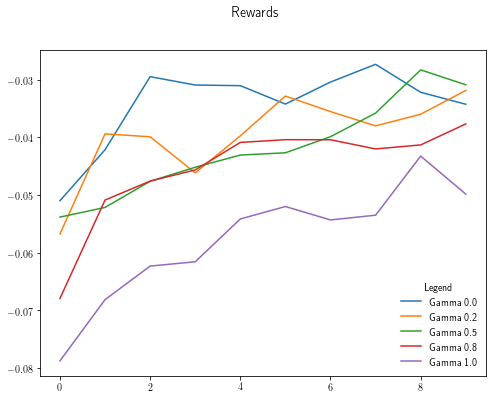

In [26]:
gamma_begin = 0.0
gamma_end = 1.0
n_episodes = 100000
rewards = mc_control_plot(n_episodes=n_episodes, n_episodes_test=n_episodes, gamma_begin=gamma_begin, gamma_end=gamma_end, eps_gen=eps_generator(eps_start=1.0, eps_min=0.01, decay=0.01**(1/n_episodes)))

fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Rewards', fontsize=15)
for i in range(len(rewards)):
    ax.plot(rewards[i], label="Gamma {:10.1f}".format(gamma_begin + (gamma_end - gamma_begin) / 4 * i))
plt.legend(loc="lower right", title="Legend", frameon=False)
plt.show()

Видим, что при маленьких значениях гаммы обучение быстрее, выигрыш выше. Построим графики с лучшим качеством и точностью для маленьких значений гаммы:

Gamma: 0.0. Episode 30000/300000. Epsilon: 0.6309670301067631. Reward: -0.037086666666666664.
Gamma: 0.0. Episode 60000/300000. Epsilon: 0.39811328177011907. Reward: -0.03233333333333333.
Gamma: 0.0. Episode 90000/300000. Epsilon: 0.25119249906759356. Reward: -0.03464.
Gamma: 0.0. Episode 120000/300000. Epsilon: 0.15849175216479358. Reward: -0.02683666666666667.
Gamma: 0.0. Episode 150000/300000. Epsilon: 0.10000153506776062. Reward: -0.03138.
Gamma: 0.0. Episode 180000/300000. Epsilon: 0.0630967030102028. Reward: -0.03063.
Gamma: 0.0. Episode 210000/300000. Epsilon: 0.03981132817671346. Reward: -0.03283.
Gamma: 0.0. Episode 240000/300000. Epsilon: 0.02511924990657108. Reward: -0.03564666666666667.
Gamma: 0.0. Episode 270000/300000. Epsilon: 0.015849175216360607. Reward: -0.031145.
Gamma: 0.0. Episode 300000/300000. Epsilon: 0.010000153506701163. Reward: -0.030415.
Gamma: 0.075. Episode 30000/300000. Epsilon: 0.6309670301067631. Reward: -0.031003333333333334.
Gamma: 0.075. Episode 6000

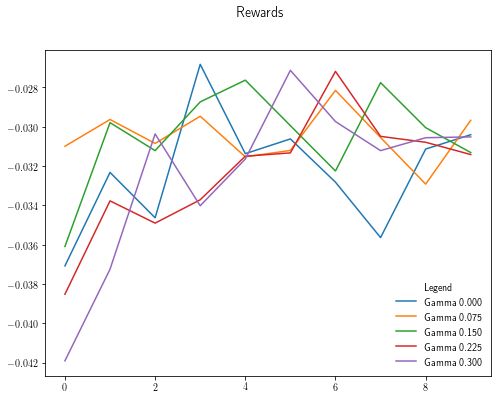

In [27]:
gamma_begin = 0.0
gamma_end = 0.3
n_episodes = 300000
rewards = mc_control_plot(n_episodes=n_episodes, n_episodes_test=n_episodes, gamma_begin=gamma_begin, gamma_end=gamma_end, eps_gen=eps_generator(eps_start=1.0, eps_min=0.01, decay=0.01**(1/n_episodes)))

fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Rewards', fontsize=15)
for i in range(len(rewards)):
    ax.plot(rewards[i], label="Gamma {:10.3f}".format(gamma_begin + (gamma_end - gamma_begin) / 4 * i))
plt.legend(loc="lower right", title="Legend", frameon=False)
plt.show()

Почему маленькие гаммы дают лучше результат, чем большие? В этой игре очень много случайностей: победа или поражение не обязательно обусловлены верными или не верными ходами, за пару ходов ситуация может сильно измениться. Поэтому награждать стоит только за 1-2 последних хода. Почему гамма не полностью нулевая? Всё таки в этой игре есть стратегия, действия игрока влияют на ход игры, хоть и случайный выбор карт сильно затмевает их влияние. Почему не заметна разница между разными маленькими значениями гаммы? Возможно, график недостаточно точный.

## Часть вторая, удвоенная
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:  
double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.  
Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.  
Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.  


In [28]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding
from gym.envs.registration import register, registry
from gym.envs.toy_text.blackjack import *

class BlackjackEnvDoubling(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        elif action == 2:
            self.player.append(draw_card(self.np_random))
            done = True
            if is_bust(self.player):
                reward = -2.
            else:
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = cmp(score(self.player), score(self.dealer)) * 2
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

gym.envs.toy_text.blackjack.BlackjackEnvDoubling = BlackjackEnvDoubling
    
if 'Blackjack-v1' in registry.env_specs:
    del registry.env_specs['Blackjack-v1']
    
register(
    id='Blackjack-v1',
    entry_point='gym.envs.toy_text.blackjack:BlackjackEnvDoubling',
)

Проверим новое окружение с удвоением ставки:

In [29]:
play_blackjack(env=gym.make("Blackjack-v1", natural=True), strategy=random_strategy, verbose=True, action_names=["Больше не берём.", "Берём карту.", "Берём одну карту и удваиваем ставку."])

Начальная раздача:  (10, 10, False)
Берём карту.
(17, 10, False) 0.0 False {}
Больше не берём.
(17, 10, False) -1.0 True {}
Поражение.


([(10, 10, False), (17, 10, False)], [1, 0], [0.0, -1.0])

Произведём обучение с подкреплением и оценим средний выигрыш:

In [30]:
%%time
n_episodes = 1000000
best_policy, Q_for_best_policy = mc_control_fast(env=gym.make('Blackjack-v1', natural=True), gamma=0.2, n_episodes=n_episodes, eps_gen=eps_generator(eps_start=1.0, eps_min=0.01, decay=0.01**(1/n_episodes)))
print(average_reward(strategy=best_policy, env=gym.make("Blackjack-v1", natural=True), n_episodes=n_episodes, Q=Q_for_best_policy, verbose=False))

Episode 100000/1000000. Epsilon: 0.6309602501516386.
Episode 200000/1000000. Epsilon: 0.3981090039074759.
Episode 300000/1000000. Epsilon: 0.25118979991863927.
Episode 400000/1000000. Epsilon: 0.15849004911687575.
Episode 500000/1000000. Epsilon: 0.10000046051712816.
Episode 600000/1000000. Epsilon: 0.0630960250145623.
Episode 700000/1000000. Epsilon: 0.039810900390368394.
Episode 800000/1000000. Epsilon: 0.025118979991624307.
Episode 900000/1000000. Epsilon: 0.01584900491153603.
Episode 1000000/1000000. Epsilon: 0.01000004605161713.
-0.0186625
CPU times: user 2min 29s, sys: 1.91 s, total: 2min 31s
Wall time: 2min 28s


Построим графики среднего выигрыша по ходу обучения:

Gamma: 0.0. Episode 10000/100000. Epsilon: 0.6309864018087341. Reward: -0.06095.
Gamma: 0.0. Episode 20000/100000. Epsilon: 0.39812550448832373. Reward: -0.052495.
Gamma: 0.0. Episode 30000/100000. Epsilon: 0.2512002110817752. Reward: -0.034455.
Gamma: 0.0. Episode 40000/100000. Epsilon: 0.15849661811701005. Reward: -0.02195.
Gamma: 0.0. Episode 50000/100000. Epsilon: 0.10000460527619258. Reward: -0.020015.
Gamma: 0.0. Episode 60000/100000. Epsilon: 0.06309864018085258. Reward: -0.025475.
Gamma: 0.0. Episode 70000/100000. Epsilon: 0.03981255044881961. Reward: -0.023225.
Gamma: 0.0. Episode 80000/100000. Epsilon: 0.02512002110816935. Reward: -0.02367.
Gamma: 0.0. Episode 90000/100000. Epsilon: 0.015849661811695913. Reward: -0.02351.
Gamma: 0.0. Episode 100000/100000. Epsilon: 0.010000460527616143. Reward: -0.022185.
Gamma: 0.25. Episode 10000/100000. Epsilon: 0.6309864018087341. Reward: -0.069135.
Gamma: 0.25. Episode 20000/100000. Epsilon: 0.39812550448832373. Reward: -0.042745.
Gamma:

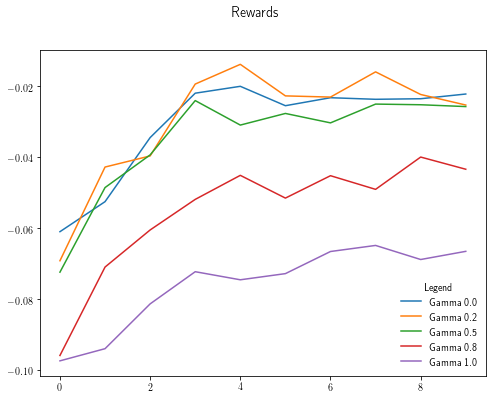

In [34]:
gamma_begin = 0.0
gamma_end = 1.0
n_episodes = 100000
rewards = mc_control_plot(env=gym.make('Blackjack-v1', natural=True), n_episodes=n_episodes, n_episodes_test=n_episodes, gamma_begin=gamma_begin, gamma_end=gamma_end, eps_gen=eps_generator(eps_start=1.0, eps_min=0.01, decay=0.01**(1/n_episodes)))

fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Rewards', fontsize=15)
for i in range(len(rewards)):
    ax.plot(rewards[i], label="Gamma {:10.1f}".format(gamma_begin + (gamma_end - gamma_begin) / 4 * i))
plt.legend(loc="lower right", title="Legend", frameon=False)
plt.show()

Gamma: 0.0. Episode 30000/300000. Epsilon: 0.6309670301067631. Reward: -0.03496166666666667.
Gamma: 0.0. Episode 60000/300000. Epsilon: 0.39811328177011907. Reward: -0.029263333333333332.
Gamma: 0.0. Episode 90000/300000. Epsilon: 0.25119249906759356. Reward: -0.023333333333333334.
Gamma: 0.0. Episode 120000/300000. Epsilon: 0.15849175216479358. Reward: -0.014196666666666666.
Gamma: 0.0. Episode 150000/300000. Epsilon: 0.10000153506776062. Reward: -0.015521666666666666.
Gamma: 0.0. Episode 180000/300000. Epsilon: 0.0630967030102028. Reward: -0.015008333333333334.
Gamma: 0.0. Episode 210000/300000. Epsilon: 0.03981132817671346. Reward: -0.017631666666666667.
Gamma: 0.0. Episode 240000/300000. Epsilon: 0.02511924990657108. Reward: -0.01579.
Gamma: 0.0. Episode 270000/300000. Epsilon: 0.015849175216360607. Reward: -0.017056666666666668.
Gamma: 0.0. Episode 300000/300000. Epsilon: 0.010000153506701163. Reward: -0.020763333333333335.
Gamma: 0.075. Episode 30000/300000. Epsilon: 0.6309670301

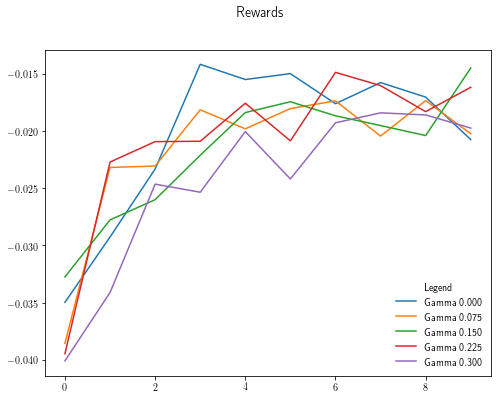

In [35]:
gamma_begin = 0.0
gamma_end = 0.3
n_episodes = 300000
rewards = mc_control_plot(env=gym.make('Blackjack-v1', natural=True), n_episodes=n_episodes, n_episodes_test=n_episodes, gamma_begin=gamma_begin, gamma_end=gamma_end, eps_gen=eps_generator(eps_start=1.0, eps_min=0.01, decay=0.01**(1/n_episodes)))

fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Rewards', fontsize=15)
for i in range(len(rewards)):
    ax.plot(rewards[i], label="Gamma {:10.3f}".format(gamma_begin + (gamma_end - gamma_begin) / 4 * i))
plt.legend(loc="lower right", title="Legend", frameon=False)
plt.show()

# Часть третья, в главной роли — Дастин Хоффман
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы.  
Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру.  
После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.  

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).  
Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.  



In [36]:
class BlackjackEnvCounting(gym.Env):
    def __init__(self, natural=False):      
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Box(-22.0, +22.0, shape=(1,1), dtype=np.float32)))
        self.seed()
        
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        self.card_counter = 0.0
        self.card_points = {
            1: -1,
            2: 0.5,
            3: 1,
            4: 1,
            5: 1.5,
            6: 1,
            7: 0.5,
            8: 0,
            9: -0.5,
            10: -1,
        }

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()
    
    def cmp(self, a, b):
        return float(a > b) - float(a < b)

    def draw_card(self, np_random):
        card = self.deck.pop(np_random.randint(0, len(self.deck)))
        self.card_counter += self.card_points[card]
        return int(card)


    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]


    def usable_ace(self, hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21


    def sum_hand(self, hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)


    def is_bust(self, hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21


    def score(self, hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)


    def is_natural(self, hand):  # Is this hand a natural blackjack?
        return sorted(hand) == [1, 10]


    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card(self.np_random))
            if self.is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:  # stick: play out the dealers hand, and score
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = self.cmp(self.score(self.player), self.score(self.dealer))
            if self.natural and self.is_natural(self.player) and reward == 1.:
                reward = 1.5
        elif action == 2:
            self.player.append(self.draw_card(self.np_random))
            done = True
            if self.is_bust(self.player):
                reward = -2.
            else:
                while self.sum_hand(self.dealer) < 17:
                    self.dealer.append(self.draw_card(self.np_random))
                reward = self.cmp(self.score(self.player), self.score(self.dealer)) * 2
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (self.sum_hand(self.player), self.dealer[0], self.usable_ace(self.player), self.card_counter)

    def reset(self):
        if len(self.deck) < 15:
            # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
            self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
            self.card_counter = 0.0
        
        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
        return self._get_obs()

gym.envs.toy_text.blackjack.BlackjackEnvCounting = BlackjackEnvCounting
    
if 'Blackjack-v2' in registry.env_specs:
    del registry.env_specs['Blackjack-v2']
    
register(
    id='Blackjack-v2',
    entry_point='gym.envs.toy_text.blackjack:BlackjackEnvCounting',
)

Проверим новое окружение с удвоением ставки и подсчётом карт в колоде:

In [37]:
env = gym.make("Blackjack-v2", natural=True)
for i in range(10):
    play_blackjack(env=env, strategy=random_strategy, verbose=True, action_names=["Больше не берём.", "Берём карту.", "Берём одну карту и удваиваем ставку."])
    print("Осталось карт в колоде: {}".format(len(env.deck)))
    print("Значение счётчика карт по системе \"Половинки\": {}".format(env.card_counter))
    print("=============================================")

Начальная раздача:  (19, 1, True, 0.0)
Больше не берём.
(19, 1, True, 0.0) -1.0 True {}
Поражение.
Осталось карт в колоде: 44
Значение счётчика карт по системе "Половинки": 0.0
Начальная раздача:  (11, 4, False, 1.0)
Больше не берём.
(11, 4, False, 0.5) 1.0 True {}
Победа.
Осталось карт в колоде: 39
Значение счётчика карт по системе "Половинки": 0.5
Начальная раздача:  (19, 2, True, 1.5)
Берём карту.
(19, 2, False, 0.5) 0.0 False {}
Больше не берём.
(19, 2, False, -0.5) 1.0 True {}
Победа.
Осталось карт в колоде: 33
Значение счётчика карт по системе "Половинки": -0.5
Начальная раздача:  (19, 9, False, -3.5)
Берём одну карту и удваиваем ставку.
(29, 9, False, -4.5) -2.0 True {}
Поражение.
Осталось карт в колоде: 28
Значение счётчика карт по системе "Половинки": -4.5
Начальная раздача:  (13, 2, False, -3.0)
Берём карту.
(23, 2, False, -4.0) -1.0 True {}
Поражение.
Осталось карт в колоде: 23
Значение счётчика карт по системе "Половинки": -4.0
Начальная раздача:  (15, 6, False, -1.5)
Больш

Произведём обучение с подкреплением и оценим средний выигрыш:

In [38]:
%%time
n_episodes = 1000000
best_policy, Q_for_best_policy = mc_control_fast(env=gym.make('Blackjack-v2', natural=True), n_episodes=n_episodes, gamma=0.2, eps_gen=eps_generator(eps_start=1.0, eps_min=0.01, decay=0.01**(1/n_episodes)))
print(average_reward(strategy=best_policy, env=gym.make("Blackjack-v2", natural=True), n_episodes=n_episodes, Q=Q_for_best_policy, verbose=False))

Episode 100000/1000000. Epsilon: 0.6309602501516386.
Episode 200000/1000000. Epsilon: 0.3981090039074759.
Episode 300000/1000000. Epsilon: 0.25118979991863927.
Episode 400000/1000000. Epsilon: 0.15849004911687575.
Episode 500000/1000000. Epsilon: 0.10000046051712816.
Episode 600000/1000000. Epsilon: 0.0630960250145623.
Episode 700000/1000000. Epsilon: 0.039810900390368394.
Episode 800000/1000000. Epsilon: 0.025118979991624307.
Episode 900000/1000000. Epsilon: 0.01584900491153603.
Episode 1000000/1000000. Epsilon: 0.01000004605161713.
-0.0076715
CPU times: user 1min 58s, sys: 783 ms, total: 1min 59s
Wall time: 1min 57s


Почти вышли в плюс.

Построим графики среднего выигрыша по ходу обучения:

Gamma: 0.0. Episode 10000/100000. Epsilon: 0.6309864018087341. Reward: -0.18853.
Gamma: 0.0. Episode 20000/100000. Epsilon: 0.39812550448832373. Reward: -0.15203.
Gamma: 0.0. Episode 30000/100000. Epsilon: 0.2512002110817752. Reward: -0.12306.
Gamma: 0.0. Episode 40000/100000. Epsilon: 0.15849661811701005. Reward: -0.103015.
Gamma: 0.0. Episode 50000/100000. Epsilon: 0.10000460527619258. Reward: -0.10018.
Gamma: 0.0. Episode 60000/100000. Epsilon: 0.06309864018085258. Reward: -0.085135.
Gamma: 0.0. Episode 70000/100000. Epsilon: 0.03981255044881961. Reward: -0.07926.
Gamma: 0.0. Episode 80000/100000. Epsilon: 0.02512002110816935. Reward: -0.06915.
Gamma: 0.0. Episode 90000/100000. Epsilon: 0.015849661811695913. Reward: -0.07477.
Gamma: 0.0. Episode 100000/100000. Epsilon: 0.010000460527616143. Reward: -0.06741.
Gamma: 0.25. Episode 10000/100000. Epsilon: 0.6309864018087341. Reward: -0.19977.
Gamma: 0.25. Episode 20000/100000. Epsilon: 0.39812550448832373. Reward: -0.17536.
Gamma: 0.25.

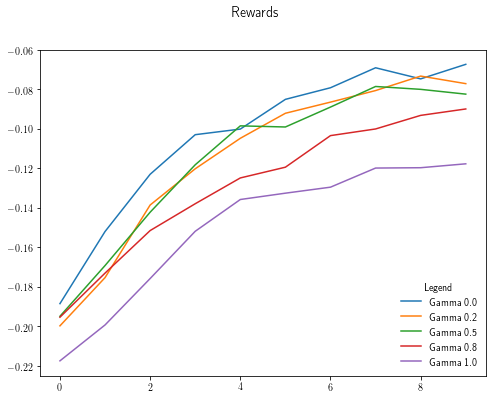

In [39]:
gamma_begin = 0.0
gamma_end = 1.0
n_episodes = 100000
rewards = mc_control_plot(env=gym.make('Blackjack-v2', natural=True), n_episodes=n_episodes, n_episodes_test=n_episodes, gamma_begin=gamma_begin, gamma_end=gamma_end, eps_gen=eps_generator(eps_start=1.0, eps_min=0.01, decay=0.01**(1/n_episodes)))

fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Rewards', fontsize=15)
for i in range(len(rewards)):
    ax.plot(rewards[i], label="Gamma {:10.1f}".format(gamma_begin + (gamma_end - gamma_begin) / 4 * i))
plt.legend(loc="lower right", title="Legend", frameon=False)
plt.show()

Gamma: 0.0. Episode 30000/300000. Epsilon: 0.6309670301067631. Reward: -0.13790833333333333.
Gamma: 0.0. Episode 60000/300000. Epsilon: 0.39811328177011907. Reward: -0.09580666666666666.
Gamma: 0.0. Episode 90000/300000. Epsilon: 0.25119249906759356. Reward: -0.06937166666666666.
Gamma: 0.0. Episode 120000/300000. Epsilon: 0.15849175216479358. Reward: -0.054121666666666665.
Gamma: 0.0. Episode 150000/300000. Epsilon: 0.10000153506776062. Reward: -0.045358333333333334.
Gamma: 0.0. Episode 180000/300000. Epsilon: 0.0630967030102028. Reward: -0.03987333333333333.
Gamma: 0.0. Episode 210000/300000. Epsilon: 0.03981132817671346. Reward: -0.04006333333333333.
Gamma: 0.0. Episode 240000/300000. Epsilon: 0.02511924990657108. Reward: -0.034578333333333336.
Gamma: 0.0. Episode 270000/300000. Epsilon: 0.015849175216360607. Reward: -0.029705.
Gamma: 0.0. Episode 300000/300000. Epsilon: 0.010000153506701163. Reward: -0.031385.
Gamma: 0.075. Episode 30000/300000. Epsilon: 0.6309670301067631. Reward:

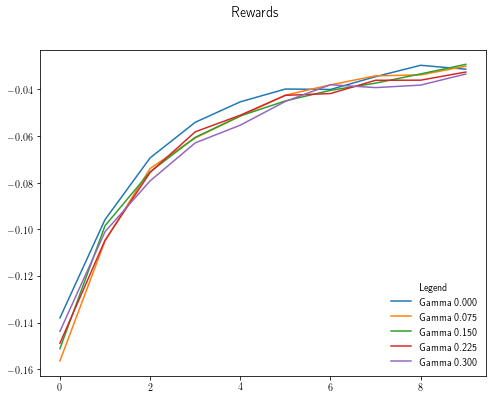

In [40]:
gamma_begin = 0.0
gamma_end = 0.3
n_episodes = 300000
rewards = mc_control_plot(env=gym.make('Blackjack-v2', natural=True), n_episodes=n_episodes, n_episodes_test=n_episodes, gamma_begin=gamma_begin, gamma_end=gamma_end, eps_gen=eps_generator(eps_start=1.0, eps_min=0.01, decay=0.01**(1/n_episodes)))

fig, ax = plt.subplots(1, figsize=(8, 6))
fig.suptitle('Rewards', fontsize=15)
for i in range(len(rewards)):
    ax.plot(rewards[i], label="Gamma {:10.3f}".format(gamma_begin + (gamma_end - gamma_begin) / 4 * i))
plt.legend(loc="lower right", title="Legend", frameon=False)
plt.show()

## Часть четвёртая, опциональная
Ну и напоследок ещё парочка опциональных заданий за дополнительные баллы.  
Реализуйте поиск стратегии в блекджеке с известной моделью из первой части, решив уравнения Беллмана для V* или Q*. Для этого вам придётся сначала оценить параметры модели, т.е. вероятности переходов между состояниями.  
Реализуйте вариант из второй или третьей части, в котором есть ещё возможность делать split: в случае, когда игроку пришли две одинаковые карты, он может разбить руку на две, внести ещё одну ставку и продолжать играть две руки сразу (как будто за двоих игроков). Скорее всего, обыграть казино получится только в варианте с разрешённым split’ом и подсчётом карт; если получится, это будет отличное завершение проекта!  


Хочется таки обыграть казино. Давайте попробуем реализовать сплит. Но с этим есть ряд проблем... Если разрешить любое количество сплитов подряд, то размер состояния будет не фиксированный. Кроме того, сплит - редкая ситуация и чтобы обучиться играть со сплитом, придётся или сыграть слишком много партий, или создавать такие ситуации искусственно. Кроме того, множество действий будет меняться по ходу игры (сплит можно делать только в начале, а после сплита появляется действие "взять карту во вторую руку"). Нужно подумать, как бы это реализовать получше.

Можно ограничить количество сплитов. Давайте разрешим только один сплит. Попробуем по-честному сделать. Но как запретить неправильные действия? Они должны сами в процессе обучения стать невыгодными, если их просто игнорировать и оставлять прежнее состояние. Но кажется, это не всегда срабатывает. Можно попробовать наказывать за них при обучении, но в игре просто игнорировать. Так же можно предоставлять информацию о разрешённых действиях и выбирать только из них.

In [206]:
class BlackjackEnvSplit(gym.Env):
    def __init__(self, natural=False):      
        self.action_space = spaces.Discrete(6) # два действия с первой рукой, два действия со второй рукой, передача хода дилеру, сплит
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Box(-22.0, +22.0, shape=(1,1), dtype=np.float32)))
        self.seed()
        
        # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
        self.deck = []
        self.card_counter = 0.0
        self.card_points = {
            1: -1,
            2: 0.5,
            3: 1,
            4: 1,
            5: 1.5,
            6: 1,
            7: 0.5,
            8: 0,
            9: -0.5,
            10: -1,
        }

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()
    
    def cmp(self, a, b):
        return float(a > b) - float(a < b)

    def draw_card(self, np_random):
        card = self.deck.pop(np_random.randint(0, len(self.deck)))
        self.card_counter += self.card_points[card]
        return int(card)


    def draw_hand(self, np_random):
        return [self.draw_card(np_random), self.draw_card(np_random)]


    def usable_ace(self, hand):  # Does this hand have a usable ace?
        return 1 in hand and sum(hand) + 10 <= 21


    def sum_hand(self, hand):  # Return current hand total
        if self.usable_ace(hand):
            return sum(hand) + 10
        return sum(hand)


    def is_bust(self, hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21


    def score(self, hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)


    def is_natural(self, hand):  # Is this hand a natural blackjack?
        return sorted(hand) == [1, 10]


    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def is_available_action(self, action):
        if action == 5:
            return len(self.player) == 2 and len(self.second_hand) == 0 and self.player[0] == self.player[1]
        elif action == 4:
            return True
        elif action == 2 or action == 3:
            return len(self.second_hand) != 0 and not self.is_bust(self.second_hand) and self.doubling_coefs[1] == 1.0
        else:
            return len(self.player) != 0 and not self.is_bust(self.player) and self.doubling_coefs[0] == 1.0
    
    def random_available_action(self):
        action = self.action_space.sample()
        while not self.is_available_action(action):
            action = self.action_space.sample()
        return action

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 5:
            # split
            if len(self.player) == 2 and len(self.second_hand) == 0 and self.player[0] == self.player[1]:
                self.second_hand.append(self.player.pop(1))
                self.player.append(self.draw_card(self.np_random))
                self.second_hand.append(self.draw_card(self.np_random))
            done = (False, False)
            reward = 0.0
        elif action == 4:
            # передать ход дилеру, больше карт не брать
            done = (True, True)
            reward = 0.0
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            if self.is_bust(self.player):
                reward -= self.doubling_coefs[0]
            elif self.natural and self.is_natural(self.player):
                assert self.doubling_coefs[0] == 1.0
                reward += self.cmp(self.score(self.player), self.score(self.dealer)) * 1.5
            else:
                reward += self.cmp(self.score(self.player), self.score(self.dealer)) * self.doubling_coefs[0]
            if len(self.second_hand) != 0:
                if self.is_bust(self.second_hand):
                    reward -= self.doubling_coefs[1]
                elif self.natural and self.is_natural(self.second_hand):
                    assert self.doubling_coefs[1] == 1.0
                    reward += self.cmp(self.score(self.second_hand), self.score(self.dealer)) * 1.5
                else:
                    reward += self.cmp(self.score(self.second_hand), self.score(self.dealer)) * self.doubling_coefs[1]
        else:
            hand_no = action // 2
            reward = 0.0
            done = (self.is_bust(self.player) or self.doubling_coefs[0] == 2.0, self.is_bust(self.second_hand) or self.doubling_coefs[1] == 2.0 or len(self.second_hand) == 0)
            if hand_no == 0 or (hand_no == 1 and len(self.second_hand) != 0):
                storage = None
                if hand_no == 0:
                    storage = self.player
                else:
                    storage = self.second_hand
                action_no = action % 2
                if action_no == 0:  # hit: add a card to players hand and return
                    reward = 0.0
                    if (not self.is_bust(storage)) and self.doubling_coefs[hand_no] == 1.0:
                        storage.append(self.draw_card(self.np_random))
                    done = (self.is_bust(self.player) or self.doubling_coefs[0] == 2.0, self.is_bust(self.second_hand) or self.doubling_coefs[1] == 2.0 or len(self.second_hand) == 0)
                    if done[0] == done[1] == True:
                        if not (self.is_bust(self.player) == self.is_bust(self.second_hand) == True):
                            while self.sum_hand(self.dealer) < 17:
                                self.dealer.append(self.draw_card(self.np_random))
                        if self.is_bust(self.player):
                            reward -= self.doubling_coefs[0]
                        elif self.natural and self.is_natural(self.player):
                            assert self.doubling_coefs[0] == 1.0
                            reward += self.cmp(self.score(self.player), self.score(self.dealer)) * 1.5
                        else:
                            reward += self.cmp(self.score(self.player), self.score(self.dealer)) * self.doubling_coefs[0]
                        if len(self.second_hand) != 0:
                            if self.is_bust(self.second_hand):
                                reward -= self.doubling_coefs[1]
                            elif self.natural and self.is_natural(self.second_hand):
                                assert self.doubling_coefs[1] == 1.0
                                reward += self.cmp(self.score(self.second_hand), self.score(self.dealer)) * 1.5
                            else:
                                reward += self.cmp(self.score(self.second_hand), self.score(self.dealer)) * self.doubling_coefs[1]
                elif action_no == 1:
                    storage.append(self.draw_card(self.np_random))
                    self.doubling_coefs[hand_no] = 2.0
                    reward = 0.0
                    done = (self.is_bust(self.player) or self.doubling_coefs[0] == 2.0, self.is_bust(self.second_hand) or self.doubling_coefs[1] == 2.0 or len(self.second_hand) == 0)
                    if done[0] == done[1] == True:
                        if not (self.is_bust(self.player) == self.is_bust(self.second_hand) == True):
                            while self.sum_hand(self.dealer) < 17:
                                self.dealer.append(self.draw_card(self.np_random))
                        if self.is_bust(self.player):
                            reward -= self.doubling_coefs[0]
                        elif self.natural and self.is_natural(self.player):
                            assert self.doubling_coefs[0] == 1.0
                            reward += self.cmp(self.score(self.player), self.score(self.dealer)) * 1.5
                        else:
                            reward += self.cmp(self.score(self.player), self.score(self.dealer)) * self.doubling_coefs[0]
                        if len(self.second_hand) != 0:
                            if self.is_bust(self.second_hand):
                                reward -= self.doubling_coefs[1]
                            elif self.natural and self.is_natural(self.second_hand):
                                assert self.doubling_coefs[1] == 1.0
                                reward += self.cmp(self.score(self.second_hand), self.score(self.dealer)) * 1.5
                            else:
                                reward += self.cmp(self.score(self.second_hand), self.score(self.dealer)) * self.doubling_coefs[1]
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (self.sum_hand(self.player), self.sum_hand(self.second_hand), self.dealer[0], self.usable_ace(self.player), self.usable_ace(self.second_hand), self.card_counter)

    def reset(self):
        if len(self.deck) < 20:
            # 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
            self.deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
            self.card_counter = 0.0
        
        self.dealer = self.draw_hand(self.np_random)
        self.player = self.draw_hand(self.np_random)
        self.second_hand = []
        self.doubling_coefs = [1.0, 1.0]
        return self._get_obs()

gym.envs.toy_text.blackjack.BlackjackEnvSplit = BlackjackEnvSplit
    
if 'Blackjack-v3' in registry.env_specs:
    del registry.env_specs['Blackjack-v3']
    
register(
    id='Blackjack-v3',
    entry_point='gym.envs.toy_text.blackjack:BlackjackEnvSplit',
)

Нужно также исправить код игрового процесса и эпсилон-жадной стратегии:

In [207]:
def play_blackjack_with_split(strategy, env=gym.make('Blackjack-v3', natural=True), verbose=False, seed=None, action_names=["Больше не берём.", "Берём карту."], *args, **kwargs): 
    """Запускает игру для указанного окружения по выбранной стратегии. 
    Записывает и возвращает историю игры: состояния, действия, вознаграждения.
    Можно напечать на экран ход игры.
    
    Аргументы:
    strategy -- Стратегия игры.
    env -- окружение для игры.
    verbose -- Нужно ли печатать ход игры?
    seed -- Начальное состояние генераторов случайных чисел для окружения.
    action_names -- Названия действий для печати хода игры.
    Остальные аргументы будут переданы в стратегию.
    """
    states, actions, rewards = [], [], []  # В эти списки запишем историю игры.
    if seed is not None:  # Инициализируем генератор случайных чисел в окружении.
        env.seed(seed)
        env.action_space.seed(seed)
    initial = env.reset()  # Начинаем новую игру
    if verbose: print("Начальная раздача: ", initial)
    while True:
        states.append(env._get_obs())
        
        action = strategy(env, *args, **kwargs)  # Выбираем действие в соответствии со стратегией.
        actions.append(action)
        if verbose:
            print(action_names[action])
        
        new_state, reward, done, info = env.step(action)  # Делаем ход.
        rewards.append(reward)
        
        if verbose: print(new_state, reward, done, info)
        if done == (True, True):  # Игра окончена
            if verbose:
                if reward > 0:
                    print("Победа.")
                elif reward < 0:
                    print("Поражение.")
                else:
                    print("Ничья.")
            break
    env.close()
    return (states, actions, rewards)

In [208]:
def eps_greedy_strategy(env, epsilon, Q):
    """Эпсилон-жадная стратегия.
    С вероятностью эпсилон выбирает случайное действие, иначе - наиболее выгодное действие.
    
    Аргументы:
    env -- Окружение.
    epsilon -- Вероятность случайного действия.
    Q -- Выгода от действий в каждом состоянии dict: key - state, value - list values of actions.
    """
    state = env._get_obs()
    if random.random() > epsilon:
        available = [(i, v) for i, v in enumerate(Q[state]) if env.is_available_action(i)]
        return max(available, key=lambda x: x[1])[0]
    else:
        return env.random_available_action()

In [209]:
random_strategy = lambda env: eps_greedy_strategy(env, 1.0, None)

Проверим, как это работает:

In [210]:
env = gym.make("Blackjack-v3", natural=True)
for i in range(10):
    play_blackjack_with_split(env=env, strategy=random_strategy, verbose=True, action_names=["Берём карту в левую руку.", "Берём одну карту в левую руку и удваиваем ставку.", "Берём карту в правую руку.", "Берём одну карту в правую руку и удваиваем ставку.", "Больше не берём карт, передаём ход дилеру", "Сплит. Играем в две руки."])
    print("Осталось карт в колоде: {}".format(len(env.deck)))
    print("Значение счётчика карт по системе \"Половинки\": {}".format(env.card_counter))
    print("=============================================")

Начальная раздача:  (13, 0, 4, True, False, -3.0)
Больше не берём карт, передаём ход дилеру
(13, 0, 4, True, False, -4.0) -1.0 (True, True) {}
Поражение.
Осталось карт в колоде: 43
Значение счётчика карт по системе "Половинки": -4.0
Начальная раздача:  (14, 0, 3, False, False, -1.5)
Берём одну карту в левую руку и удваиваем ставку.
(21, 0, 3, False, False, 0.0) 2.0 (True, True) {}
Победа.
Осталось карт в колоде: 36
Значение счётчика карт по системе "Половинки": 0.0
Начальная раздача:  (9, 0, 6, False, False, 3.0)
Больше не берём карт, передаём ход дилеру
(9, 0, 6, False, False, 2.0) 1.0 (True, True) {}
Победа.
Осталось карт в колоде: 31
Значение счётчика карт по системе "Половинки": 2.0
Начальная раздача:  (13, 0, 8, False, False, 1.5)
Берём карту в левую руку.
(23, 0, 8, False, False, 0.5) -1.0 (True, True) {}
Поражение.
Осталось карт в колоде: 26
Значение счётчика карт по системе "Половинки": 0.5
Начальная раздача:  (16, 0, 8, False, False, -0.5)
Берём карту в левую руку.
(20, 0, 8, 

Посмотрим, какой выигрыш будет при выборе случайных действий:

In [167]:
print(average_reward(strategy=random_strategy, env=gym.make("Blackjack-v3", natural=True), n_episodes=1000000, verbose=True, play_function=play_blackjack_with_split))

Episode 100000/1000000.
Episode 200000/1000000.
Episode 300000/1000000.
Episode 400000/1000000.
Episode 500000/1000000.
Episode 600000/1000000.
Episode 700000/1000000.
Episode 800000/1000000.
Episode 900000/1000000.
Episode 1000000/1000000.
-0.5696725


Количество состояний теперь стало значительно больше, чем раньше, поэтому увеличим количество итераций для обучения и подсчёта среднего.

In [212]:
%%time
n_episodes = 50000000
best_policy, Q_for_best_policy = mc_control_fast(env=gym.make('Blackjack-v3', natural=True), n_episodes=n_episodes, gamma=0.2, eps_gen=eps_generator(eps_start=1.0, eps_min=0.01, decay=0.01**(1/n_episodes)), play_function=play_blackjack_with_split)
print(average_reward(strategy=best_policy, env=gym.make("Blackjack-v3", natural=True), n_episodes=n_episodes, Q=Q_for_best_policy, verbose=True, play_function=play_blackjack_with_split))

Episode 5000000/50000000. Epsilon: 0.6309574026424183.
Episode 10000000/50000000. Epsilon: 0.3981072072821964.
Episode 15000000/50000000. Epsilon: 0.25118866634463166.
Episode 20000000/50000000. Epsilon: 0.15848933389261122.
Episode 25000000/50000000. Epsilon: 0.10000000924904832.
Episode 30000000/50000000. Epsilon: 0.06309574028866546.
Episode 35000000/50000000. Epsilon: 0.03981072074363022.
Episode 40000000/50000000. Epsilon: 0.025118866644189303.
Episode 45000000/50000000. Epsilon: 0.015848933395397762.
Episode 50000000/50000000. Epsilon: 0.010000000928778537.
Episode 5000000/50000000.
Episode 10000000/50000000.
Episode 15000000/50000000.
Episode 20000000/50000000.
Episode 25000000/50000000.
Episode 30000000/50000000.
Episode 35000000/50000000.
Episode 40000000/50000000.
Episode 45000000/50000000.
Episode 50000000/50000000.
-0.00734787
CPU times: user 2h 12min 41s, sys: 13.2 s, total: 2h 12min 54s
Wall time: 2h 14min 22s


Выйти в плюс так и не получилось. Возможно, если поподбирать гамму, то можно добиться результата лучше, но на этом я остановлюсь. В блэкджек играть не стоит )